In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [9]:
import pandas as pd

In [10]:
train = pd.read_csv('train_data.csv')
test = pd.read_csv('test_data.csv')
val = pd.read_csv('val_data.csv')

In [11]:
train.sample(5)

,X,y
60734,ap croats voted sunday whether to give preside...,1
17467,what having twins is not enough patricia and k...,3
35513,six players from both clemson and south caroli...,2
11325,seoul south korea wimbledon champion maria sha...,2
5664,bangkok millions of volunteers led by emergenc...,1


In [12]:
test.sample(5)

,X,y
10057,armoured vehicles massed on gaza 39s border fr...,1
15795,chicago reuters blockbuster inc on tuesday sai...,3
18811,after a shaky first half eli manning showed wh...,2
9319,london reuters wall street was set for a stead...,3
14307,tokyo sept 29 reuters the yen held off from si...,3


In [13]:
val.sample(5)

,X,y
3826,if investors thought things could only get bet...,3
6415,david jones limited djs said today that it exp...,3
2282,three new models are designed for businesses a...,4
2748,britain hopes to use a summit in ethiopia this...,1
3464,nearly two years after filing for bankruptcy p...,4


In [14]:
train.shape, test.shape, val.shape

((89320, 2), (19140, 2), (19140, 2))

In [15]:
train['y'] = train['y'] - 1
val['y'] = val['y'] - 1
test['y'] = test['y'] - 1

In [16]:
import numpy as np

In [17]:
glove_path = 'glove.6B.100d.txt'

def load_embeddings(glove_path):
    embeddings = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

glove_embeddings = load_embeddings(glove_path)

In [18]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [19]:
max_words = 20000
max_len = 100

In [20]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train['X'])

X_train_seq = tokenizer.texts_to_sequences(train['X'])
X_val_seq = tokenizer.texts_to_sequences(val['X'])
X_test_seq = tokenizer.texts_to_sequences(test['X'])

X_train = pad_sequences(X_train_seq, maxlen=max_len)
X_val = pad_sequences(X_val_seq, maxlen=max_len)
X_test = pad_sequences(X_test_seq, maxlen=max_len)

In [21]:
X_train[:1]

array([[    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,   817,    19,   891,     3,  8380,     2,   473,     3,
        14986,     1,  2913,     4,    36,   179,   883,  1802, 16016,
            6,  1319,     1,   802,  1087,  7590,  7765,     6,  3668,
         5888]], dtype=int32)

In [22]:
embedding_dim = 100
word_index = tokenizer.word_index
word_index

{'the': 1,
 'a': 2,
 'to': 3,
 'of': 4,
 'in': 5,
 'and': 6,
 'on': 7,
 'for': 8,
 'that': 9,
 '39s': 10,
 'with': 11,
 'as': 12,
 'is': 13,
 'its': 14,
 'at': 15,
 'said': 16,
 'it': 17,
 'by': 18,
 'has': 19,
 'new': 20,
 'an': 21,
 'from': 22,
 'his': 23,
 'will': 24,
 'was': 25,
 'reuters': 26,
 'after': 27,
 'have': 28,
 'be': 29,
 'their': 30,
 'are': 31,
 'over': 32,
 'he': 33,
 'us': 34,
 'ap': 35,
 'two': 36,
 'but': 37,
 'first': 38,
 'this': 39,
 'more': 40,
 'monday': 41,
 'not': 42,
 'tuesday': 43,
 'wednesday': 44,
 'thursday': 45,
 'company': 46,
 'up': 47,
 'inc': 48,
 'friday': 49,
 'one': 50,
 'they': 51,
 'world': 52,
 'yesterday': 53,
 'last': 54,
 'york': 55,
 'against': 56,
 'who': 57,
 'than': 58,
 'were': 59,
 'about': 60,
 'into': 61,
 'year': 62,
 'been': 63,
 'president': 64,
 'out': 65,
 'yous': 66,
 'had': 67,
 'when': 68,
 'would': 69,
 'million': 70,
 'corp': 71,
 'oil': 72,
 'united': 73,
 'week': 74,
 'sunday': 75,
 'years': 76,
 'which': 77,
 'people':

In [23]:
len(word_index)

80474

In [24]:
num_words = min(max_words, len(word_index) + 1)

embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = glove_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, Input

num_classes = 4

model = Sequential([       
    Input(shape=(num_words,)),
    Embedding(num_words, 
              embedding_dim, 
              weights=[embedding_matrix], 
              trainable=False), 
    Bidirectional(LSTM(64)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(num_classes, activation='softmax') 
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 20000, 100)     │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,088,740 (7.97 MB)

 Trainable params: 88,740 (346.64 KB)

 Non-trainable params: 2,000,000 (7.63 MB)

In [26]:
history = model.fit(
    X_train, train['y'],
    epochs=10,
    batch_size=64,
    validation_data=(X_val, val['y']),
    verbose=1,
)

Epoch 1/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 33s 23ms/step - accuracy: 0.8649 - loss: 0.3927 - val_accuracy: 0.8933 - val_loss: 0.3060
Epoch 2/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - accuracy: 0.8930 - loss: 0.3089 - val_accuracy: 0.8951 - val_loss: 0.2963
Epoch 3/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - accuracy: 0.9023 - loss: 0.2822 - val_accuracy: 0.9051 - val_loss: 0.2662
Epoch 4/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 32s 23ms/step - accuracy: 0.9092 - loss: 0.2614 - val_accuracy: 0.9062 - val_loss: 0.2602
Epoch 5/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - accuracy: 0.9118 - loss: 0.2519 - val_accuracy: 0.9077 - val_loss: 0.2524
Epoch 6/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - accuracy: 0.9174 - loss: 0.2344 - val_accuracy: 0.9121 - val_loss: 0.2496
Epoch 7/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 30s 21ms/step - accuracy: 0.9217 - loss: 0.2230 - val_accuracy: 0.9130 - val_loss: 0.2438
Epoch 8/10
1396/1396 ━━━━━━━━━━━━━━━━━━━━ 31s 22ms/step - accuracy: 0.9252 -

In [27]:
test_loss, test_accuracy = model.evaluate(X_test, test['y'], verbose=1)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9134 - loss: 0.2585
Test Loss: 0.2585
Test Accuracy: 0.9134


In [28]:
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)
y_test_pred = model.predict(X_test)

2792/2792 ━━━━━━━━━━━━━━━━━━━━ 23s 8ms/step
599/599 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step
599/599 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step


In [29]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

train_accuracy = accuracy_score(train['y'], np.argmax(y_train_pred, axis = 1))
train_f1_score = f1_score(train['y'], np.argmax(y_train_pred, axis = 1), average='weighted')
val_accuracy = accuracy_score(val['y'], np.argmax(y_val_pred, axis = 1))
val_f1_score = f1_score(val['y'], np.argmax(y_val_pred, axis = 1), average='weighted')
test_accuracy = accuracy_score(test['y'], np.argmax(y_test_pred, axis = 1))
test_f1_score = f1_score(test['y'], np.argmax(y_test_pred, axis = 1), average='weighted')

print(f"Train Accuracy: {train_accuracy*100:.2f}%")
print(f"Validation Accuracy: {val_accuracy*100:.2f}%")
print(f"Test Accuracy: {test_accuracy*100:.2f}% \n")
print(f"Train F1 Score: {train_f1_score:.2f}")
print(f"Validation F1 Score: {val_f1_score:.2f}")
print(f"Test F1 Score: {test_f1_score:.2f} \n")

class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

print(classification_report(test['y'],np.argmax(y_test_pred, axis = 1), target_names=class_names, digits=4))

Train Accuracy: 94.24%
Validation Accuracy: 91.20%
Test Accuracy: 91.34% 

Train F1 Score: 0.94
Validation F1 Score: 0.91
Test F1 Score: 0.91 

              precision    recall  f1-score   support

       World     0.9439    0.8894    0.9159      4785
      Sports     0.9677    0.9695    0.9686      4785
    Business     0.8658    0.8980    0.8816      4785
    Sci/Tech     0.8804    0.8968    0.8885      4785

    accuracy                         0.9134     19140
   macro avg     0.9144    0.9134    0.9136     19140
weighted avg     0.9144    0.9134    0.9136     19140



In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [32]:
cm = confusion_matrix(test['y'], np.argmax(y_test_pred, axis=1))
cm

array([[4256,   92,  243,  194],
       [  58, 4639,   53,   35],
       [ 104,   30, 4297,  354],
       [  91,   33,  370, 4291]])

<Axes: >

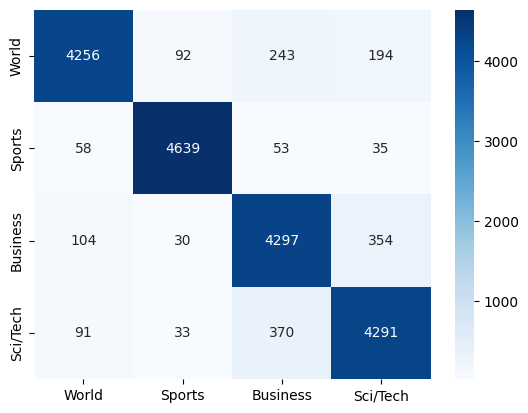

In [33]:
sns.heatmap(cm,annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names )